--- Stage 1: Sampling all parameters ---
Initial logL = -5628.68
Acceptance rate: 0.008
Mode of alpha: 0.304 (True: 0.300)

--- Stage 2: Fixing alpha, sampling beta and gamma ---
Initial logL = -3065.62
Acceptance rate: 0.024
Mode of beta: 5.987 (True: 6.000)
Mode of gamma: 10.500 (True: 10.500)


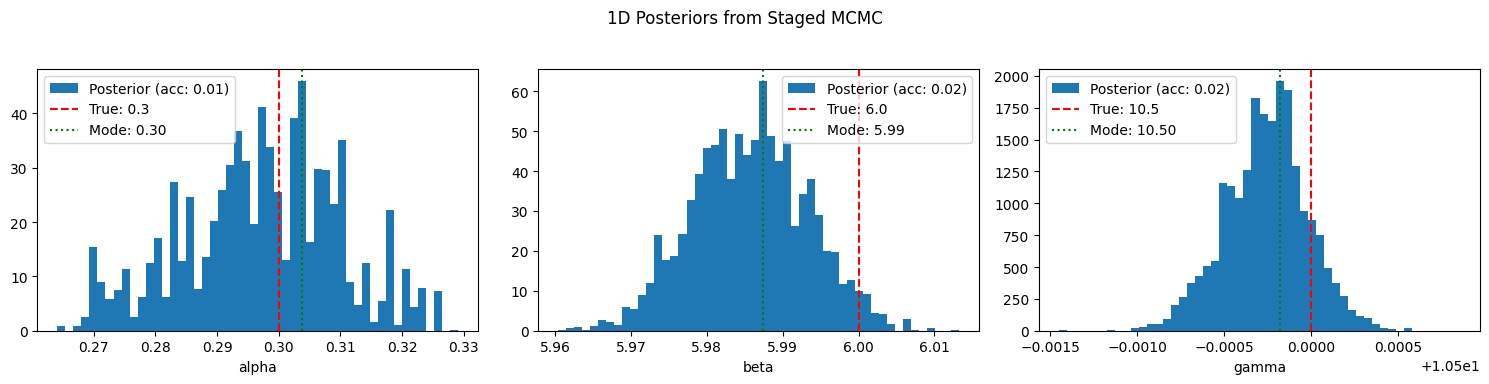

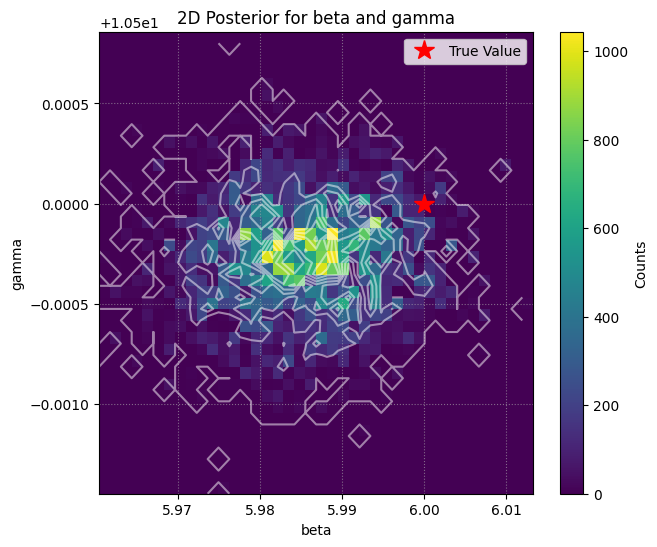

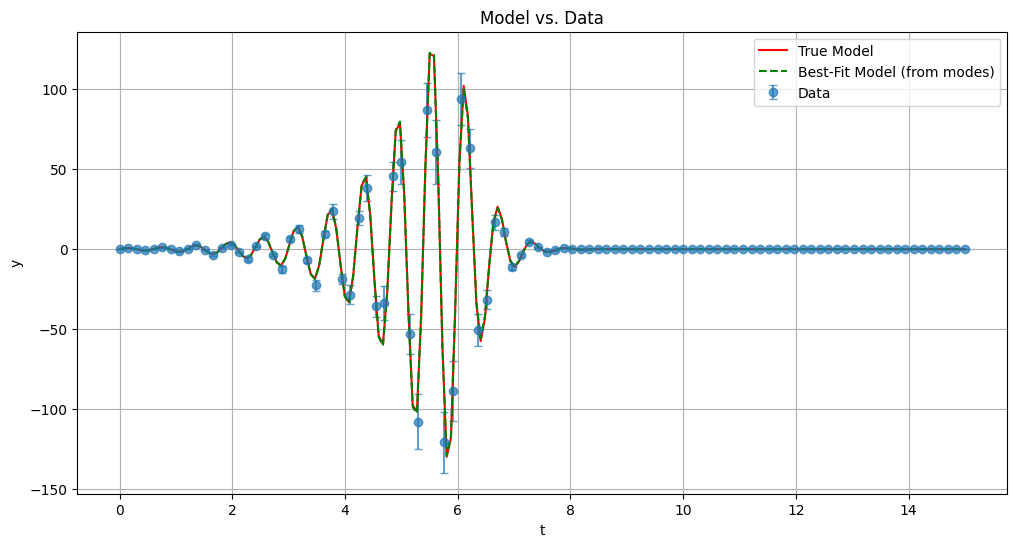

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode

# --- 1. True model and data generation ---
true_params = np.array([0.3, 6.0, 10.5])
labels = ["alpha", "beta", "gamma"]

def model(t, theta):
    alpha, beta, gamma = theta
    return alpha * np.exp(t) * (1 - np.tanh(2 * (t - beta))) * np.sin(gamma * t)

# Generate data
t_dense = np.linspace(0, 15, 200)
y_true_dense = model(t_dense, true_params)
t = np.linspace(0, 15, 100)
y_true = model(t, true_params)
bound_value = 100
good_points = (-bound_value < y_true) & (y_true < bound_value)
t = t[good_points]
y_true = y_true[good_points]
y_err_std = 0.2 * np.abs(y_true) + 1e-9  # Use abs for std dev
np.random.seed(42) # for reproducibility
y_data = y_true + np.random.normal(0, y_err_std)

# --- 2. MCMC setup ---
def log_likelihood(theta):
    y_model = model(t, theta)
    # Use the positive standard deviation for the error term
    chi2 = np.sum(((y_data - y_model) / y_err_std)**2)
    return -0.5 * chi2

def propose(theta, sigma):
    return theta + np.random.normal(0, sigma)

def in_bounds(theta):
    a, b, c = theta
    return 0 < a < 2 and 1 < b < 10 and 1 < c < 20

def mh_sampler(loglik_fn, start, prop_sigma, bounds_fn, n_sample=50000, burn=10000):
    chain = []
    theta = start
    logL = loglik_fn(theta)
    print(f"Initial logL = {logL:.2f}") # Check initial logL
    accept = 0
    for i in range(n_sample + burn):
        theta_new = propose(theta, prop_sigma)
        if not bounds_fn(theta_new):
            if i >= burn: chain.append(theta)
            continue
        logL_new = loglik_fn(theta_new)
        if not np.isfinite(logL_new):
            logL_new = -np.inf # Penalize unstable parameters
        A = np.exp(np.minimum(0, logL_new - logL))
        if np.random.rand() < A:
            theta, logL = theta_new, logL_new
            accept += 1
        if i >= burn: chain.append(theta)
    return np.array(chain), accept / (n_sample + burn)

def get_mode(chain, n_bins=50):
    counts, bins = np.histogram(chain, bins=n_bins)
    return (bins[np.argmax(counts)] + bins[np.argmax(counts) + 1]) / 2


# --- 3. Stage 1: Sample all parameters ---
print("--- Stage 1: Sampling all parameters ---")
start_all = np.array([0.5, 5.0, 10.0])
# Using smaller proposal steps
chain1, acc1 = mh_sampler(log_likelihood, start_all, [0.005, 0.02, 0.02], in_bounds, n_sample=70000)
alpha_mode = get_mode(chain1[:, 0])
print(f"Acceptance rate: {acc1:.3f}")
print(f"Mode of alpha: {alpha_mode:.3f} (True: {true_params[0]:.3f})")


# --- 4. Stage 2: Fix alpha and sample beta, gamma ---
print("\n--- Stage 2: Fixing alpha, sampling beta and gamma ---")
def loglik_bg(bg):
    return log_likelihood(np.array([alpha_mode, bg[0], bg[1]]))

def in_bounds_bg(bg):
    return in_bounds(np.array([alpha_mode, bg[0], bg[1]]))

start_bg = np.array([5.0, 10.0])
# Using smaller proposal steps
chain2, acc2 = mh_sampler(loglik_bg, start_bg, [0.01, 0.01], in_bounds_bg, n_sample=100000)
beta_mode = get_mode(chain2[:, 0])
gamma_mode = get_mode(chain2[:, 1])
print(f"Acceptance rate: {acc2:.3f}")
print(f"Mode of beta: {beta_mode:.3f} (True: {true_params[1]:.3f})")
print(f"Mode of gamma: {gamma_mode:.3f} (True: {true_params[2]:.3f})")


# --- 5. Visualization ---
# 1D Histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
chains = [chain1[:, 0], chain2[:, 0], chain2[:, 1]]
modes = [alpha_mode, beta_mode, gamma_mode]
for i in range(3):
    axs[i].hist(chains[i], bins=50, density=True, label=f'Posterior (acc: {acc1 if i==0 else acc2:.2f})')
    axs[i].axvline(true_params[i], color='r', linestyle='--', label=f'True: {true_params[i]}')
    axs[i].axvline(modes[i], color='g', linestyle=':', label=f'Mode: {modes[i]:.2f}')
    axs[i].set_xlabel(labels[i])
    axs[i].legend()
fig.suptitle('1D Posteriors from Staged MCMC')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2D Contour Plot for beta-gamma
plt.figure(figsize=(7, 6))
H, xedges, yedges = np.histogram2d(chain2[:, 0], chain2[:, 1], bins=40)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(H.T, origin='lower', extent=extent, cmap='viridis', aspect='auto')
plt.colorbar(label='Counts')
plt.contour(xedges[:-1], yedges[:-1], H.T, colors='white', alpha=0.5)
plt.plot(true_params[1], true_params[2], 'r*', markersize=15, label='True Value')
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('2D Posterior for beta and gamma')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# Final Model vs Data Plot
best_fit_params = [alpha_mode, beta_mode, gamma_mode]
plt.figure(figsize=(12, 6))
plt.errorbar(t, y_data, yerr=np.abs(y_err_std), fmt='o', label='Data', capsize=3, alpha=0.7)
plt.plot(t_dense, y_true_dense, 'r-', label='True Model')
plt.plot(t_dense, model(t_dense, best_fit_params), 'g--', label='Best-Fit Model (from modes)')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Model vs. Data')
plt.legend()
plt.grid(True)
plt.show()
